<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/model_calibration_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter estimation for hydraulic model calibration and fault detection


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a hydraulic model of the EXNING DMA, in use by Anglian Water in early 2019 (no record of recent calibration),
* pipe groups (based on material & age) and corresponding ranges of H-W coefficients,
* hourly loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days in December 2019.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions (max. 100-150 words per question) based on your results. Don't forget to include titles, labels and legends in your plots, and watch for significant figures in your reporting!

You have also been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* According to AW's existing records, EXNING contains mostly old, cast iron pipes.
* The "reservoir" head  and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [1]:
# run this cell once
import sys
import os

# if 'google.colab' in sys.modules:
#   !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
#   !pip install wntr
#   !pip install cvxpy
#   !apt-get install libsuitesparse-dev && pip install scikit-sparse

In [2]:
# load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [3]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/Users/mayar/Desktop/ICL/4Y/STOIANOW/coursework/functions/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [4]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = './parameter_estimation/'
    net_dir = './networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

In [5]:
wdn

WDN(A12=<299x290 sparse matrix of type '<class 'numpy.int64'>'
	with 596 stored elements in Compressed Sparse Row format>, A10=<299x1 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>, net_info={'np': 299, 'nn': 290, 'n0': 1, 'nt': 96, 'headloss': 'H-W', 'units': 'LPS', 'reservoir_names': ['reservoir_1'], 'junction_names': ['node_0066', 'node_0067', 'node_0068', 'node_0069', 'node_0070', 'node_0071', 'node_0072', 'node_0073', 'node_0074', 'node_0075', 'node_0076', 'node_0077', 'node_0078', 'node_0079', 'node_0080', 'node_0081', 'node_0082', 'node_0083', 'node_0084', 'node_0085', 'node_0086', 'node_0087', 'node_0088', 'node_0089', 'node_0090', 'node_0091', 'node_0092', 'node_0093', 'node_0094', 'node_0095', 'node_0096', 'node_0097', 'node_0098', 'node_0099', 'node_0100', 'node_0101', 'node_0102', 'node_0103', 'node_0104', 'node_0105', 'node_0106', 'node_0107', 'node_0108', 'node_0109', 'node_0110', 'node_0111', 'node_0112', 'node_0113

Plot sensor nodes in network. We provide a plotting function below.

In [6]:
#### DO NOT CHANGE THIS ####
# network plotting function
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info
    h0_df = wdn.h0_df

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=100, node_shape='s', node_color='black')

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(uG, pos, sensor_names, node_size=100, node_shape='o', node_color='red', edgecolors='white')

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, verticalalignment='top')
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] - 1500)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, verticalalignment='bottom')
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1000)

    # plot sensor vals
    if vals is not None:

        cmap = cm.get_cmap('RdYlGn_r')

        # plot residuals
        nx.draw_networkx_nodes(uG, pos, nodelist=sensor_names, node_size=100, node_shape='o', node_color=vals, cmap=cmap, edgecolors='white')

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

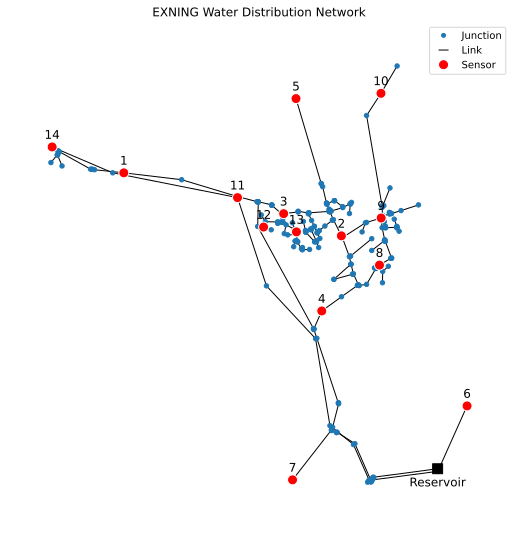

In [7]:
import matplotlib.lines as mlines

# Define the figure size
plt.figure(figsize=(7, 7))

# Create custom legend entries
sensor_legend = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Sensor')
node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# Plot the network
plot_network(wdn, sensor_idx)
plt.legend(handles=[node_legend, link_legend, sensor_legend], loc='best')
plt.title('EXNING Water Distribution Network')
# Display the plot
plt.show()

### Preliminary model evaluation

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [8]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

Run simulation with initial $C_0$ values.

In [9]:
C_0 = link_df['C'].to_numpy()
q_0, h_0 = hydraulic_solver(inp_file=os.path.join(net_dir, net_name),
                            d_data=d_data,
                            h0_data=h0_data,
                            C=C_0,
                            demand=False)  # Assuming demand=False as default function setting

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

In [10]:
print("h_data shape:", h_data.shape)
print("h_0 shape:", h_0.shape)
print("Max index in sensor_idx:", max(sensor_idx))

h_data shape: (14, 96)
h_0 shape: (290, 96)
Max index in sensor_idx: 283


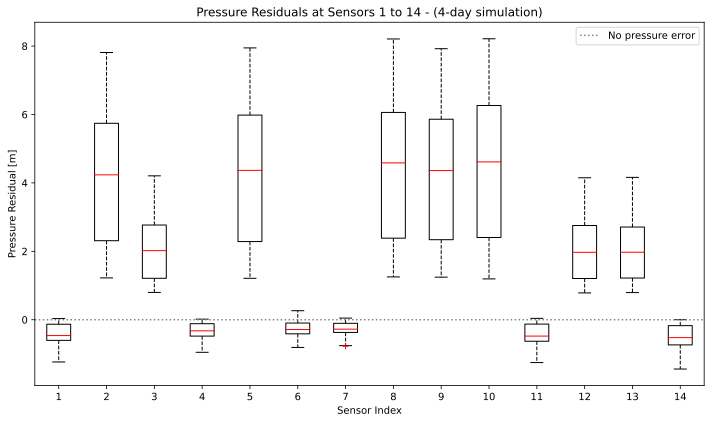

In [30]:
# Compute pressure residuals

# The residuals are the differences between simulated heads (h_0) & measured heads (h_data) at sensor nodes
residuals_0 = h_0[sensor_idx, :] - h_data

# Extract labels directly from sensor indices and network information, from the function plot_network() above
net_info = wdn.net_info  # Assuming 'wdn' is network object, as mentioned in the function
sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
sensor_labels_dict = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}

# Convert sensor_labels_dict to a list in the correct order for boxplot
labels = [sensor_labels_dict[node] for node in sensor_names]

# Boxplot of pressure residuals at sensor nodes
plt.figure(figsize=(10, 6))
plt.boxplot(residuals_0.T, # Transpose to have the correct dimensions for boxplot
            flierprops={'marker': '+', 'markeredgecolor': 'red'},
            medianprops={'color': 'red'},
            whiskerprops={'linestyle': '--'}, 
            )

plt.xlabel('Sensor Index')
plt.ylabel('Pressure Residual [m]')
plt.title('Pressure Residuals at Sensors 1 to 14 - (4-day simulation)')

# Add a dotted horizontal line at y=0 to highlight the zero residual level
plt.axhline(y=0, color='grey', linestyle='dotted', label='No pressure error')
plt.legend(loc='upper right')  # Adding the legend for the dotted line

# Adjusting x-ticks
plt.xticks(range(1, len(labels) + 1), labels)  # Rotate by 45 degrees and align right

plt.tight_layout()  # Adjusts layout so everything fits
plt.show()

**<u>Question 1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.

_Sensors 1, 4, 6, 7, 11, 14, show acceptable residuals = within ±2m H2O._

_Sensors 2, 3, 5, 8, 9, 10, 12, 13 have positive pressure residuals. On average, the hydraulic simulation model is overpredicting pressure heads (or underpredicting head losses) at these locations._

_Water demand, a time-dependent parameter, and pipe roughness, which varies in space, are both the most uncertain input parameters in a hydraulic model as they are not directly measurable._

_The Box&Whiskers indicates that cluster A: (2, 5, 8, 9, 10) shows larger positive residuals than cluster B: (3, 12, 13), with a difference of around 7m between simulated and measured pressures for A. In EXNING map below, clusters A(red dots) & B(yellow dots) have a distinct spatial separation which indicates localised issues in the system._

_Assuming accurate load/field and elevation data, sources of errors are:_
* _Aleatory (i.e. spatial and temporal variability in water demand)_
* _Epistemic (i.e. incomplete system knowledge):_
_Uncertainty in the hydraulic model, such as pipe roughness._
_Possible changes in network connectivity during the simulation._

 



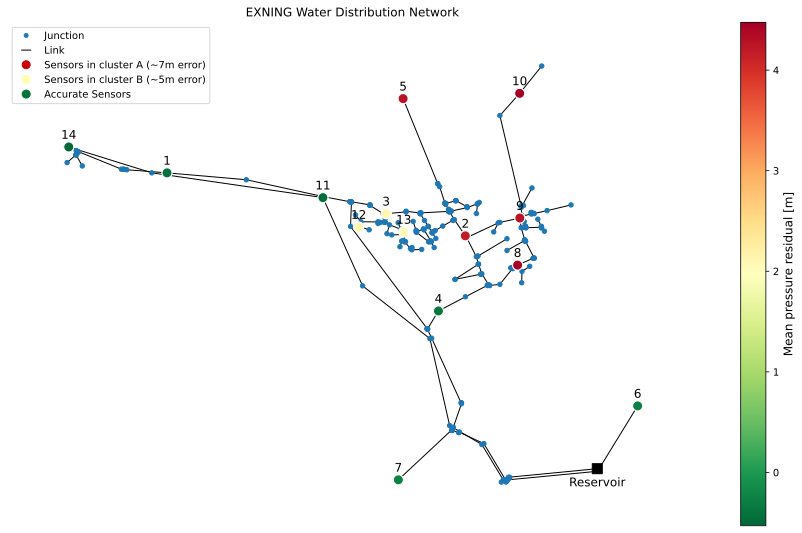

In [34]:
# Generate EXNING map to display localised issue

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import networkx as nx

# Define the figure size
plt.figure(figsize=(12, 7))

# Create legend entries
sensor_legendA = mlines.Line2D([], [], color=(200/255, 0/255, 5/255), marker='o', linestyle='None', markersize=8, label='Sensors in cluster A (~7m error)')
sensor_legendB = mlines.Line2D([], [], color=(254/255, 254/255, 174/255), marker='o', linestyle='None', markersize=8, label='Sensors in cluster B (~5m error)')
sensor_legendC = mlines.Line2D([], [], color=(0/255, 117/255, 56/255), marker='o', linestyle='None', markersize=8, label='Accurate Sensors')

node_legend = mlines.Line2D([], [], marker='o', linestyle='None', markersize=4, label='Junction')
link_legend = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Link')

# Plot the network
mean_residuals_0 = np.mean(residuals_0, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_0)
plt.legend(handles=[node_legend, link_legend, sensor_legendA, sensor_legendB, sensor_legendC], loc='upper left')

plt.title('EXNING Water Distribution Network')
plt.show()


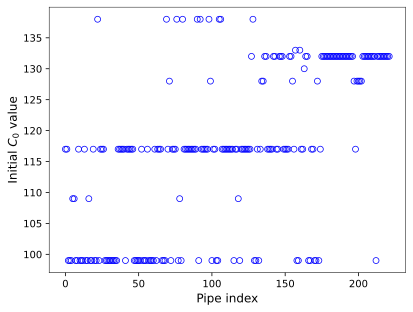

In [35]:
# Generate plot to display C_0 values for pipes only
pipe_C = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel(r'Initial $C_0$ value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

### Part 1: parameter estimation without pipe grouping + valves fixed

Based on the outcome of the initial comparison between measured and simulated heads at sensor nodes, you are tasked with the calibration of the hydraulic model of EXNING. Given the information provided by Anglian Water about the EXNING system, the first step is to adjust the pipe roughness (H-W) coefficients. In order to limit the number of parameters in question, and regardless of your answer to question 1, you will first assume (in Parts 1 and 2 of the coursework) that the status of valves is known and minor/local loss coefficients are fixed to C=0.2 (fully open).

First, you will investigate the effect of pipe grouping on the calibration of H-W coefficients. In Part 1, you will solve the model calibration problem without pipe grouping. Complete the code below to calibrate the network model using the head measurements loaded previously.

#### Separate the data into train and test datasets
We suggest you use the first day worth of data (loading conditions + $h_0$ measurements) as a train dataset, and the remaining three (3) days as a test dataset.

In [15]:
# Define the number of time steps for one day's worth of data
nt_train = 24

# train data (24 hours worth of data)
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data (three remaining days)
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}


**<u>Question 2:</u>** Briefly comment on the definition of the train dataset. What impact may it have on the predictive ability of your model? (i.e. what range of conditions will you confidently be able to use your model for?)

_A train dataset is a subset of data used to train an ML model, which will be tested on unknown data to evaluate its generalisation performance._

_Here, the train dataset is not granular enough (loading conditions + $h_0$ measurements for 24h only), which might not generalise well. We do not know ahead whether the data corresponds to a weekday, weekend or a holiday._

_Therefore, although the model could perform well for a range of conditions similar to that specific day, its ability to predict different conditions from this single day is limited and may lead to overfitting. Training a model on a limited dataset might make it too tailored to the network conditions, reservoir heads, demand patterns for that specific 1st day of data._ 

#### Definition of the loss function
The calibration of H-W coefficients is a model fitting/parameter estimation problem. In particular, for the hydraulic model calibration problem, the loss function is defined as the mean squared error (MSE) between simulated and measured heads at sensor locations:

In [16]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx, :] - h_data )**2 )

Compute MSE for `C_0` values and using the training data.

In [17]:
h_0 = h_0[:, :nt_train]
mse_0 = loss_fun(h_0, data_train['h_data'])
mse_0

9.705407324726352

**<u>Question 3:</u>**  Justify the choice/definition of `loss_fun`.

_The MSE gives more importance to large errors due to the squaring of differences between the observed head values h (at specific sensor locations sensor_idx) and the predicted values h_data. It punishes the model for larger deviations of simulated pressures from reference values. We know that large deviations are most likely due to the incorrect estimation of pipe roughnesses. In turn, MSE would lead to a more accurate fitting of the H-W coefficients, and, therefore, to a better model overall. Moreover, MSE is convex, which ensures it can be combined with cvxpy as the objective function._

#### Solve the parameter estimation problem using the train dataset

The following function is needed for the sequential convex programming (SCP) method used in this coursework. <font color="blue">As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [18]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

Solve the model calibration problem without pipe grouping using the `cvxpy` modelling interface. (Use the code provided previously.)

In [36]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 1e-4

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]

    # variable bounds
    lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

NameError: name 'data_train' is not defined

**<u>Question 4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

_After each iteration, the SCP adjusts flow rates q, hydraulic heads h and the H-W coefs theta to minimize the MSE (objval_k). The algorithm uses an adaptive trust region delta_k to control how much theta can change and cautiously explore the space. A successful iteration lead to a 10% increase of delta_k, alternatively to a 75% decrease of delta_k._
_The objective value objval_k indicates the model fits at iteration k. objval_k, or the MSE, decreases as the fit improves._ 
_Ki measures the relative improvement of the model, guiding when to terminate the iterations. The algorithm adaptively adjusts delta_k based on each iteration's success, increasing it for successful iterations and decreasing it otherwise, striking a balance between exploring new solutions and fine-tuning existing ones._

Store the solution (i.e. new coefficients `theta_k`) as $C_1$.

In [ ]:
C_1 = theta_k

# compute train mse
mse_train_1 = loss_fun(h_k, data_train['h_data'])
mse_train_1

0.1398310117247181

#### Evaluate test model error
Compute the MSE and plot the pressure residuals corresponding to the test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_1)

# compute test mse
mse_test_1 = loss_fun(h_test, data_test['h_data'])
mse_test_1

0.14406154879895686

Text(0, 0.5, 'Pressure residual [m]')

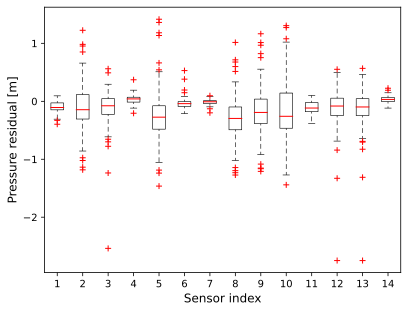

In [ ]:
# compute pressure residuals
residuals_1 = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_1.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

**<u>Question 5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

<font color="red">Enter response here...

#### Discuss the values of the calibrated H-W coefficients $C_1$
Visualise the values of newly calibrated coefficients $C_1$ compared to original model coefficients $C_0$.

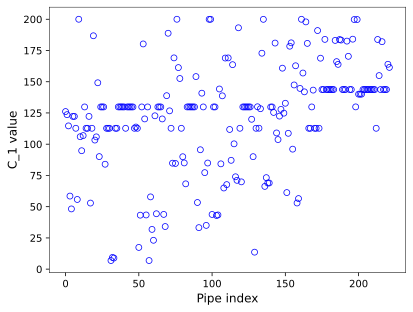

In [ ]:
# C_1 value scatter plot (pipes only)
pipe_C = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('C_1 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

**<u>Question 6:</u>** Comment on the values of parameter estimates in $C_1$ and explain the results of the calibration without pipe grouping. Can the new model be considered calibrated?

<font color="red">Enter response here...

### Part 2: parameter estimation with pipe grouping + valves fixed
In order to reduce the underdeterminedness of the model calibration problem (and improve the quality of estimated H-W coefficients), pipes can be grouped based on their material and age. In particular, all pipes of a group are assumed to share the same H-W coefficient. This also allows tighter bounds on the grouped coefficient estimates (stored in $\Theta_{\text{lb}}$ and $\Theta_{\text{ub}}$, for lower and upper bounds, respectively) in the formulation of the parameter estimation problem. Here, you will still assume the status of valves is known with minor/local loss coefficients fixed to C=0.2. Use the code provided in Week 5 and modify as necessary below to calibrate the hydraulic model with pipe grouping, using the same train data as before. (Note that Part 2 might take a little longer to run than Part 1.)

Load pipe grouping information.

In [ ]:
link_groups = data['G'][0] - 1 # matlab to python index offset
ng = link_groups.shape[0]
thetaG_lo = data['thetaG_min'][:, 0]
thetaG_up = data['thetaG_max'][:, 0]

#### Solve the parameter estimation problem using the train dataset
Solve the model calibration problem with pipe grouping. (Use the code provided previously and modify as necessary.)

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 0

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

### main scp code ###
for k in range(iter_max):

    # insert code here...

     # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])
    thetaG = cp.Variable(ng)

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]
    
    # pipe grouping constraints
    for j in range(ng):
        
        # equality constraints
        for idx in link_groups[j]:
            constraints += [
                theta[idx] == thetaG[j]
            ]
            
        # pipe grouping bounds
        constraints += [
            thetaG[j] >= thetaG_lo[j],
            thetaG[j] <= thetaG_up[j]
        ]

    # C bounds
    lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += lower_bound_pipe
    upper_bound_pipe = [theta[idx] <= C_up_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
    constraints += upper_bound_pipe

    # valve minor loss coefficient constraints
    valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    thetaG_tilde = thetaG.value
    q_tilde, h_tilde = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        thetaG_k = thetaG_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.742920598867365 0.5113115359121628 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 3.7299769601458403 0.21356959654003513 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 3.7299769601458403 0.21356959654003513 6.050000000000001 

Iteration 3 unsuccessful! Return to previous estimate and reduce trust region size. 

3 3.7299769601458403 0.21356959654003513 1.5125000000000002 

Iteration 4 unsuccessful! Return to previous estimate and reduce trust region size. 

4 3.7299769601458403 0.21356959654003513 0.37812500000000004 

Iteration 5 unsuccessful! Return to previous estimate and reduce trust region size. 

5 3.7299769601458403 0.21356959654003513 0.09453125000000001 



Store the solution (i.e. new coefficients `theta_k`) as $C_2$.

In [ ]:
C_2 = theta_k

# compute train mse
mse_train_2 = loss_fun(h_k, data_train['h_data'])
mse_train_2

3.7299769601458403

#### Evaluate test model error
Compute the MSE and plot the pressure residuals corresponding to the test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_2)

# compute test mse
mse_test_2 = loss_fun(h_test, data_test['h_data'])
mse_test_2

3.515229909003735

Text(0, 0.5, 'Pressure residual [m]')

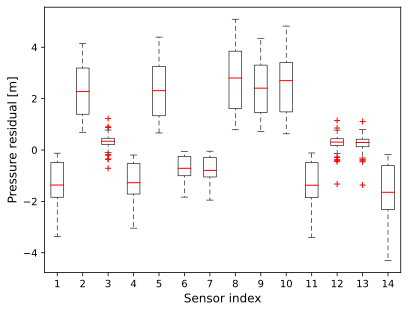

In [ ]:
# compute pressure residuals
residuals_2 = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_2.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

**<u>Question 7:</u>** Comment on the improvement in model accuracy after calibration with pipe grouping.

<font color="red">Enter response here...

#### Discuss the values of the calibrated H-W coefficients $C_2$
Visualise the values of newly calibrated coefficients $C_2$ compared to model coefficients $C_1$ and $C_0$.

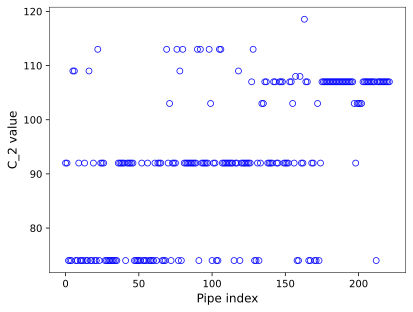

In [ ]:
# C_2 value scatter plot (pipes only)
pipe_C = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('C_2 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

**<u>Question 8:</u>** Comment on the values of the H-W coefficient estimates $C_2$ and justify the results of the calibration with pipe grouping.

<font color="red">Enter response here...

**<u>Question 9:</u>** Can the newly calibrated model (with H-W coefficients in $C_2$) be considered calibrated? Considering the results of Part 2, as well as your answer to question 1, provide an interpretation of the remaining pressure/head residuals.

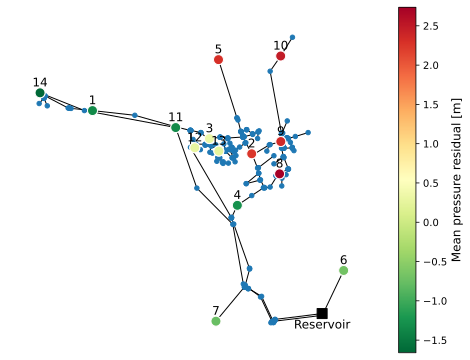

In [ ]:
# spatial residuals plot (hint: you can use `plot_network` function`)
# spatial residuals plot
mean_residuals_2 = np.mean(residuals_2, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_2)

<font color="red">Enter response here...

### Part 3: parameter estimation with pipe grouping + valve coefficients free

Following initial reports concerning discrepancies in the EXNING model, AW were able to confirm that:
* flow and head sensors had been calibrated before collection of load/field data corresponding to the train and test datasets,
* allocation of demands in the train and test dataset is representative of normal network conditions and based on recent demand monitoring campaigns (incl. of large industrial users), and
* boundary valves (isolating EXNING from adjacent DMAs) are closed.

As a result, the remaining deviations between measured and simulated pressures must result from unknown/unreported changes in system connectivity. Errors associated with unknown valve status (e.g. closed valves) can be identified by solving a similar parameter estimation problem where valve coefficients, in addition to H-W coefficients, are free to vary.

In Part 3, you are encouraged to propose and investigate an approach to calibrate the hydraulic model with unknown valve coefficients. You may follow the suggested steps below, or come up with your own. Marks will be allocated based on the justification of the adopted approach (show your thinking!) and discussion of the obtained results in question 10, whether they lead to a firm conclusion about the existence/location of unknowingly closed valves or not.

Suggested approach:
1. Try modifying the CVXPY implementation in Part 2 to allow valve coefficients to vary. Solve the resulting parameter estimation problem and interpret the optimal value of $C_3$.
2. Next, try further modifying your CVXPY implementation to account for the expected sparsity of large valve coefficients (hint: you might want to consider regularising your problem formulation). Solve the resulting problem and comment on the optimal value of $C_3$.
3. Finally, compare the results of Part 3 with your answer to question 1 and preliminary model evaluation. Explain whether they contradict or corroborate your previous conclusions about the most likely sources of error in the EXNING model by answering question 10 below.

In [ ]:
# insert Part 3 code here...

link_groups = data['G'][0] - 1 # matlab to python index offset
ng = link_groups.shape[0]
thetaG_lo = data['thetaG_min'][:, 0]
thetaG_up = data['thetaG_max'][:, 0]

# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf 
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 0
C_lo_valve = 0.2
C_up_valve = 5e3

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data)

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])
    thetaG = cp.Variable(ng)

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    objective = cp.Minimize(loss)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]
    
    # pipe grouping constraints
    for j in range(ng):
        
        # equality constraints
        for idx in link_groups[j]:
            constraints += [
                theta[idx] == thetaG[j]
            ]
            
        # pipe grouping bounds
        constraints += [
            thetaG[j] >= thetaG_lo[j],
            thetaG[j] <= thetaG_up[j]
        ]

#     # C bounds
#     lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
#     constraints += lower_bound_pipe
#     upper_bound_pipe = [theta[idx] <= C_up_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
#     constraints += upper_bound_pipe
    lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_valve
    upper_bound_valve = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_valve

#     # valve minor loss coefficient constraints
#     valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
#     constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    thetaG_tilde = thetaG.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        thetaG_k = thetaG_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 2.664580610638627 0.7254540153250337 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.6873992489804828 0.36672989278561957 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 1.3801024540134474 0.1821126773362631 26.620000000000005 

Iteration 3 successful! Update estimate and increase trust region size. 

3 1.1950544321642698 0.13408281487439092 29.282000000000007 

Iteration 4 successful! Update estimate and increase trust region size. 

4 1.0323835596106847 0.136120052924271 32.21020000000001 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.8764909266345882 0.15100263029651906 35.43122000000001 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.7275436662350492 0.1699358839588257 38.974342000000014 

Iteration 7 successful! Update estimate and increase trust region size

In [ ]:
C_3a = theta_k

# compute train mse
mse_train_3a = loss_fun(h_k, data_train['h_data'])
mse_train_3a

0.25797245643031713

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_3a)

# compute test mse
mse_test_3a = loss_fun(h_test, data_test['h_data'])
mse_test_3a

0.26677215823114164

Text(0, 0.5, 'Pressure residual [m]')

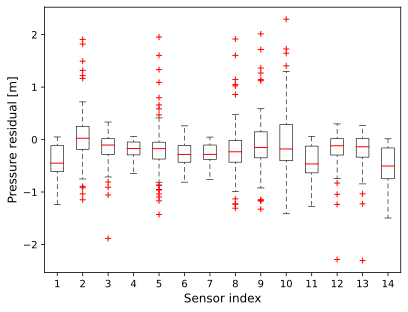

In [ ]:
# compute pressure residuals
residuals_3a = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_3a.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

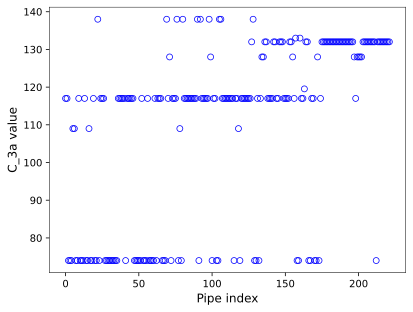

In [ ]:
# C_3a value scatter plot (pipes)
pipe_C = [C_3a[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('C_3a value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

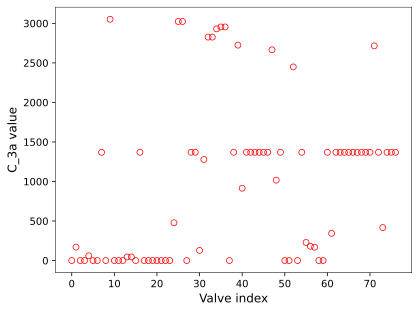

In [ ]:
# C_3a value scatter plot (valves)
valve_C = [C_3a[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='r',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=12)
ax.set_ylabel('C_3a value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

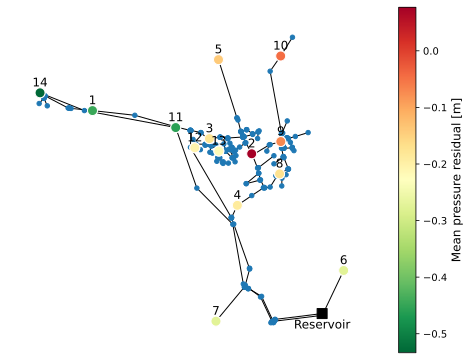

In [ ]:
# spatial residuals plot
mean_residuals_3a = np.mean(residuals_3a, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_3a)

In [ ]:
valve_idx = link_df.index[link_df['link_type'] == 'valve'].tolist()
rho = 1e-2
def valve_reg_fun(theta):
    return rho * (1 / len(valve_idx)) * la.norm(C_0[valve_idx] - theta[valve_idx], 1)

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf 
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 0
C_lo_valve = 0.2
C_up_valve = 5e3

# initialise values
theta_k = C_0
q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_k)
a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
objval_k = loss_fun(h_k, h_data) + valve_reg_fun(theta_k)

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = cp.Variable((net_info['np'], nt_train))
    h = cp.Variable((net_info['nn'], nt_train))
    theta = cp.Variable(net_info['np'])
    thetaG = cp.Variable(ng)

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
    valve_reg = rho * (1 / len(valve_idx)) * cp.norm(C_0[valve_idx] - theta[valve_idx], 1)
    objective = cp.Minimize(loss + valve_reg)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
            A12.T @ q[:, t] == d[:, t]
        ]

    # trust region constraints
    constraints += [
        cp.norm(theta - theta_k, 'inf') <= delta_k
    ]
    
    # pipe grouping constraints
    for j in range(ng):
        
        # equality constraints
        for idx in link_groups[j]:
            constraints += [
                theta[idx] == thetaG[j]
            ]
            
        # pipe grouping bounds
        constraints += [
            thetaG[j] >= thetaG_lo[j],
            thetaG[j] <= thetaG_up[j]
        ]

    # C bounds
#     lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
#     constraints += lower_bound_pipe
#     upper_bound_pipe = [theta[idx] <= C_up_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
#     constraints += upper_bound_pipe
    lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += lower_bound_valve
    upper_bound_valve = [theta[idx] <= C_up_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
    constraints += upper_bound_valve

#         # valve minor loss coefficient constraints
#         valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
#         constraints += valve_constraints

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    thetaG_tilde = thetaG.value
    [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), d, h0, C=theta_tilde)
    objval_tilde = loss_fun(h_tilde, h_data) + valve_reg_fun(theta_tilde)

    predicted_decrease = objval_k - cvx_val
    actual_decrease = objval_k - objval_tilde

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        thetaG_k = thetaG_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

Iteration 0 successful! Update estimate and increase trust region size. 

0 4.875645664625583 0.4976361628631539 22.0 

Iteration 1 unsuccessful! Return to previous estimate and reduce trust region size. 

1 4.875645664625583 0.4976361628631539 5.5 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 4.875645664625583 0.4976361628631539 1.375 

Iteration 3 unsuccessful! Return to previous estimate and reduce trust region size. 

3 4.875645664625583 0.4976361628631539 0.34375 

Iteration 4 unsuccessful! Return to previous estimate and reduce trust region size. 

4 4.875645664625583 0.4976361628631539 0.0859375 



In [ ]:
C_3b = theta_k

# compute train mse
mse_train_3b = loss_fun(h_k, data_train['h_data'])
mse_train_3b

2.6756456513366444

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(os.path.join(net_dir, net_name), data_test['d'], data_test['h0'], C=C_3b)

# compute test mse
mse_test_3b = loss_fun(h_test, data_test['h_data'])
mse_test_3b

2.553673184420488

Text(0, 0.5, 'Pressure residual [m]')

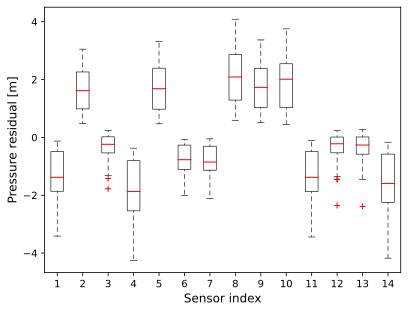

In [ ]:
# compute pressure residuals
residuals_3b = h_test[sensor_idx,:] - data_test['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_3b.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

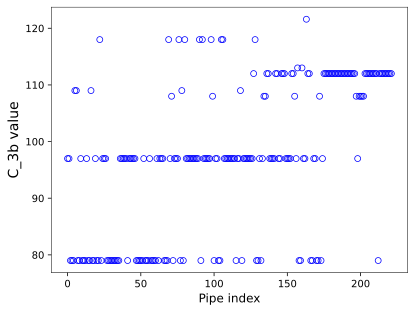

In [ ]:
# C_3b value scatter plot (pipes)
pipe_C = [C_3b[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('C_3b value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

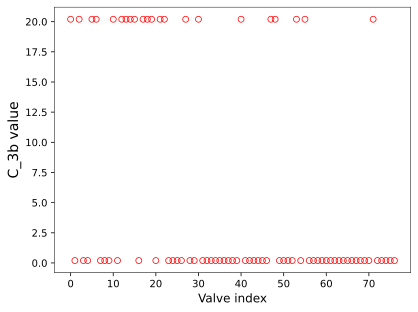

In [ ]:
# C_3b value scatter plot (valves)
valve_C = [C_3b[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='r',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=12)
ax.set_ylabel('C_3b value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

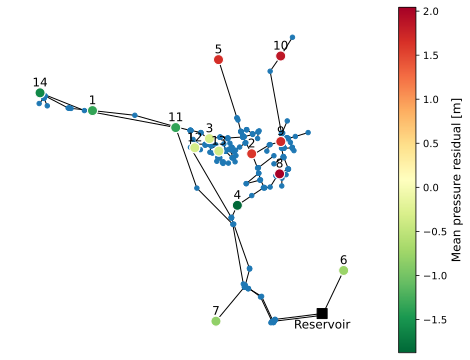

In [ ]:
# spatial residuals plot
mean_residuals_3b = np.mean(residuals_3b, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_3b)

In [ ]:
# find indices of faulty valves and corresponding downstream nodes
valve_C = [idx for idx in valve_idx if C_3b[idx] > 100]
valve_nodes = link_df.loc[valve_C, 'node_out'].tolist()

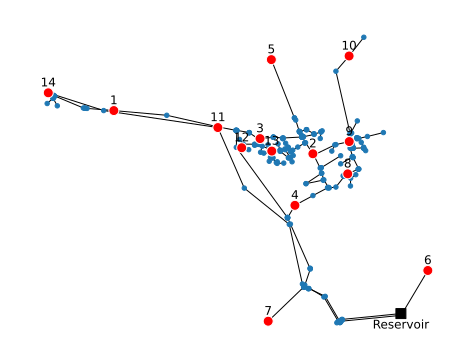

In [ ]:
plot_network(wdn, sensor_idx, highlight_valves=valve_nodes)

**<u>Question 10:</u>** Summarise your findings and provide recommendations to AW to validate your proposed hydraulic model update. Provide plots to support your recommendations.

<font color="red">Enter response here...